
Running simulation with LinUCB-Meta algorithm...
Initialized simulation with 100 drivers and 244 potential trips
Simulation period: 2025-01-01 08:00:00 to 2025-01-01 10:00:00
Riders will automatically cancel after 10 minutes of waiting
Starting simulation at 2025-01-01 08:00:00


100%|██████████| 120.0/120.0 [00:04<00:00, 29.74it/s]


Simulation completed at 2025-01-01 10:00:00

Simulation Results:
Total Completed Trips: 150
Total Cancelled Rides: 94
Cancellation Rate: 38.52%
Average Waiting Time: 425.49 seconds
Average Trip Time: 1063.23 seconds
Average Driver Earnings: $12.12
Average Empty Miles: 1.91 miles
Driver Earnings Gini Coefficient: 0.2345
Bandit Meta-Selector decision log saved.

Running simulation with Hungarian algorithm...
Initialized simulation with 100 drivers and 244 potential trips
Simulation period: 2025-01-01 08:00:00 to 2025-01-01 10:00:00
Riders will automatically cancel after 10 minutes of waiting
Starting simulation at 2025-01-01 08:00:00


100%|██████████| 120.0/120.0 [00:19<00:00,  6.20it/s]


Simulation completed at 2025-01-01 10:00:00

Simulation Results:
Total Completed Trips: 152
Total Cancelled Rides: 92
Cancellation Rate: 37.70%
Average Waiting Time: 415.63 seconds
Average Trip Time: 1071.42 seconds
Average Driver Earnings: $12.37
Average Empty Miles: 1.86 miles
Driver Earnings Gini Coefficient: 0.2409

Running simulation with Stable Matching algorithm...
Initialized simulation with 100 drivers and 244 potential trips
Simulation period: 2025-01-01 08:00:00 to 2025-01-01 10:00:00
Riders will automatically cancel after 10 minutes of waiting
Starting simulation at 2025-01-01 08:00:00


100%|██████████| 120.0/120.0 [00:00<00:00, 1230.91it/s]


Simulation completed at 2025-01-01 10:00:00

Simulation Results:
Total Completed Trips: 150
Total Cancelled Rides: 94
Cancellation Rate: 38.52%
Average Waiting Time: 430.51 seconds
Average Trip Time: 1061.26 seconds
Average Driver Earnings: $12.12
Average Empty Miles: 1.94 miles
Driver Earnings Gini Coefficient: 0.2362


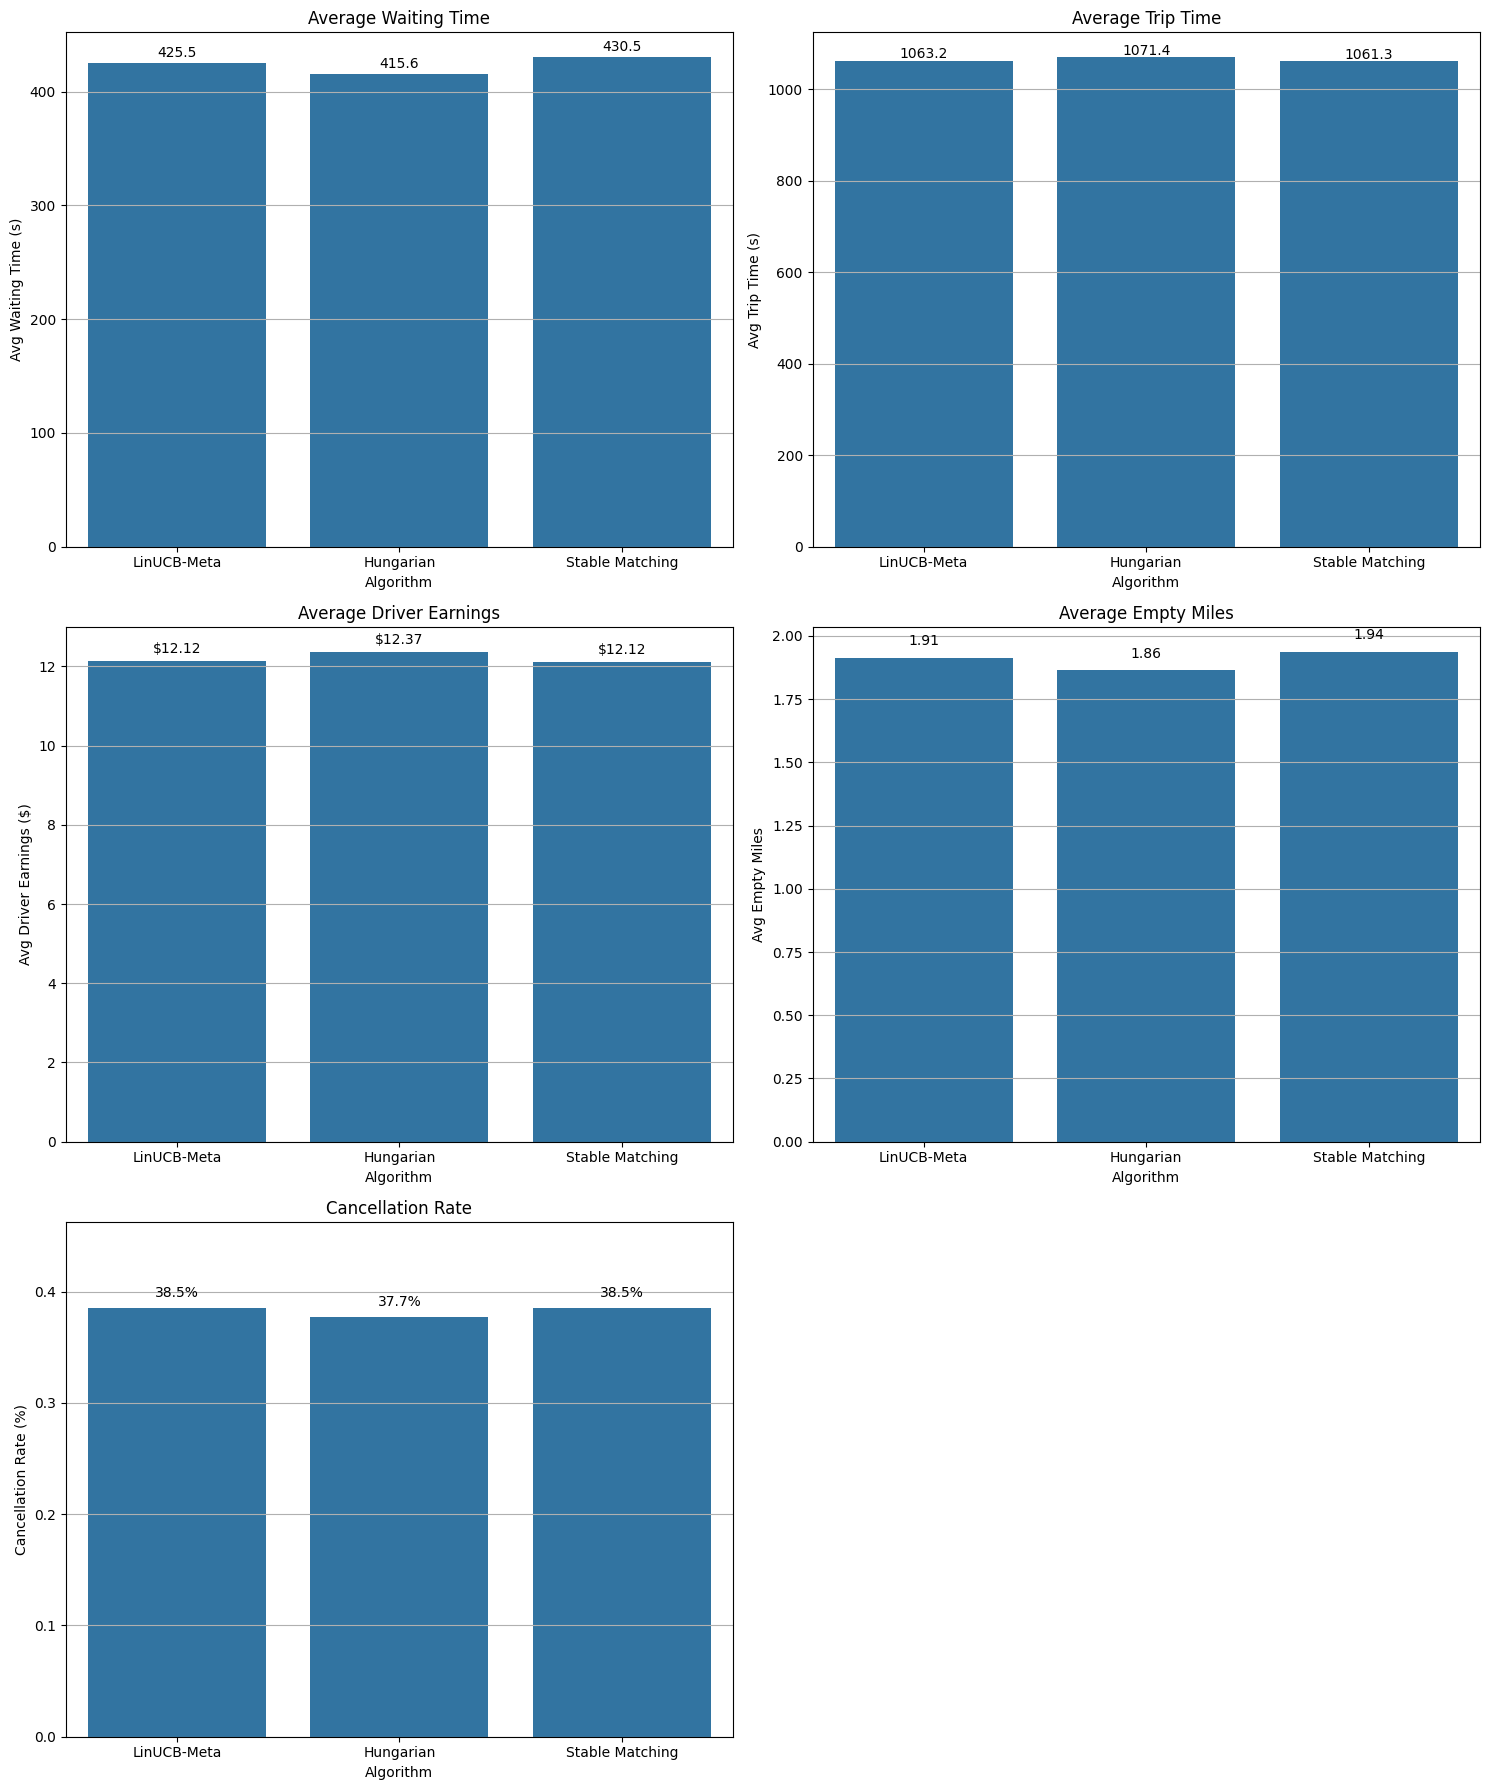

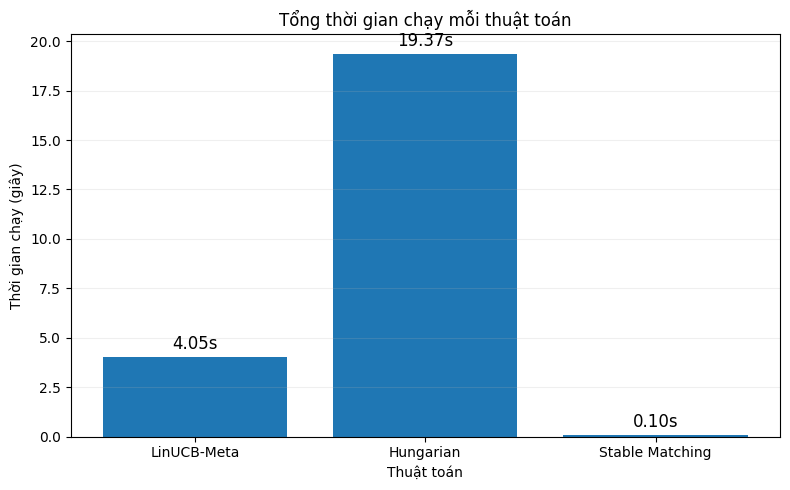

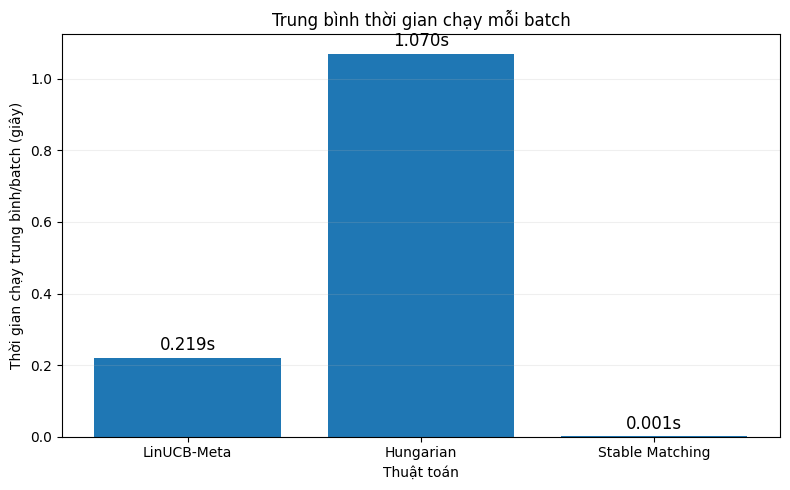

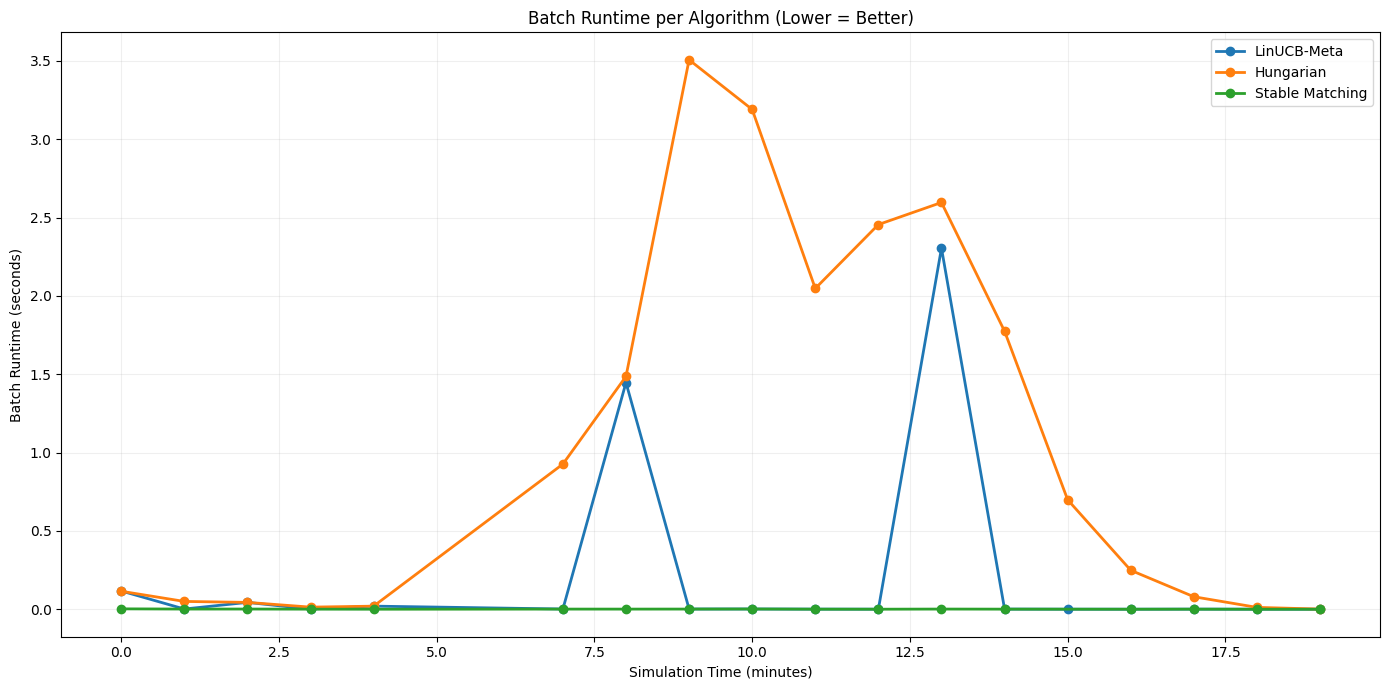


Algorithm Comparison Summary:
-----------------------------
total_completed_trips: LinUCB-Meta: 150.00, Hungarian: 152.00, Stable Matching: 150.00
total_cancelled_rides: LinUCB-Meta: 94.00, Hungarian: 92.00, Stable Matching: 94.00
cancellation_rate: LinUCB-Meta: 0.3852, Hungarian: 0.3770, Stable Matching: 0.3852
avg_waiting_time: LinUCB-Meta: 425.49, Hungarian: 415.63, Stable Matching: 430.51
avg_trip_time: LinUCB-Meta: 1063.23, Hungarian: 1071.42, Stable Matching: 1061.26
avg_driver_earnings: LinUCB-Meta: 12.12, Hungarian: 12.37, Stable Matching: 12.12
avg_empty_miles: LinUCB-Meta: 1.91, Hungarian: 1.86, Stable Matching: 1.94
gini_coefficient: LinUCB-Meta: 0.2345, Hungarian: 0.2409, Stable Matching: 0.2362
runtime_seconds: LinUCB-Meta: 4.05s, Hungarian: 19.37s, Stable Matching: 0.10s


In [1]:
from algorithms import *
from models import *
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from enviroments import *
from algorithms import *
import random

def run_algorithm_comparison(trip_data_path, zone_data_path, start_date, end_date):
    """
    Run comparison of different matching algorithms with consistent driver initialization
    
    Args:
        trip_data_path: Path to trip data
        zone_data_path: Path to zone data
        start_date: Simulation start date
        end_date: Simulation end date
    """
    city = City(zone_data_path)
    trip_df = pd.read_parquet(trip_data_path)
    city.central_zone_id = trip_df['PULocationID'].value_counts().idxmax()
    algo_list = [BatchedHungarianAlgorithm(), StableMatchingAlgorithm()]
    algo_names = ["Hungarian", "Stable"]
    context_dim = 5  # Số feature trong build_context
    linucb = LinUCBAgent(n_arms=2, context_dim=context_dim, alpha=0.4)
    bandit_algo = BanditMatchingAlgorithm(algo_list, linucb, algo_names, beta=1.0)  # beta có thể tuning

    # Define algorithms to test
    algorithms = [
        ('LinUCB-Meta', bandit_algo),
        ('Hungarian', BatchedHungarianAlgorithm()),
        ('Stable Matching', StableMatchingAlgorithm()),
    ]
    
    # Results storage
    all_metrics = []
    algorithm_names = []
    all_simulations = []  # Store each Simulation object for runtime plotting

    # ---------------------------------------
    # Generate consistent driver initialization
    # ---------------------------------------
    np.random.seed(2)
    random.seed(2)
    NUM_DRIVERS = 100
    pickup_dist = trip_df['PULocationID'].value_counts(normalize=True)
    initial_driver_locations = []
    for i in range(NUM_DRIVERS):
        driver_id = f"D{i:05d}"
        if len(pickup_dist) > 0:
            location_id = np.random.choice(pickup_dist.index, p=pickup_dist.values)
        else:
            location_id = np.random.choice(city.zones['LocationID'].values)
        initial_driver_locations.append((driver_id, location_id))
    original_init_drivers = Simulation._initialize_synthetic_drivers
    def consistent_driver_init(self, num_drivers):
        """Create drivers with consistent initial locations across algorithm runs"""
        for driver_id, location_id in initial_driver_locations:
            self.drivers[driver_id] = Driver(driver_id, location_id)
            
    # Run simulations with each algorithm
    for name, algorithm in algorithms:
        print(f"\nRunning simulation with {name} algorithm...")
        Simulation._initialize_synthetic_drivers = consistent_driver_init
        sim = Simulation(city, algorithm)
        sim.initialize_from_data(
            driver_data_path=None,
            trip_data_path=trip_data_path,
            start_date=start_date,
            end_date=end_date,
            batch_interval_minutes=1,
            max_wait_time_minutes=10,
            num_drivers=NUM_DRIVERS,
        )
        start_time = time.time()
        sim.run()
        duration = time.time() - start_time
        metrics = sim.metrics.copy()
        metrics['runtime_seconds'] = duration
        all_metrics.append(metrics)
        algorithm_names.append(name)
        all_simulations.append(sim)
        if hasattr(sim.matching_algorithm, "history"):
            history = sim.matching_algorithm.history
            history_df = pd.DataFrame(history)
            history_df.to_csv("bandit_matching_history.csv", index=False)
            print("Bandit Meta-Selector decision log saved.")
    Simulation._initialize_synthetic_drivers = original_init_drivers

    # So sánh và plot các chỉ số
    # Dùng analyzer của simulation cuối, nhưng truyền dữ liệu mọi thuật toán
    analyzer = SimulationAnalyzer(all_simulations[-1])
    analyzer.plot_metrics_comparison(all_metrics, algorithm_names)
    plt.show()

    analyzer.plot_total_runtime_bar(all_metrics, algorithm_names)
    plt.show()

    analyzer.plot_avg_batch_runtime_bar(all_simulations, algorithm_names)
    plt.show()

    analyzer.plot_batch_runtime_comparison(all_simulations, algorithm_names)
    plt.show()
    
    print("\nAlgorithm Comparison Summary:")
    print("-----------------------------")
    comparison_df = pd.DataFrame(all_metrics, index=algorithm_names)
    metrics_to_show = [
        'total_completed_trips', 'total_cancelled_rides', 'cancellation_rate',
        'avg_waiting_time', 'avg_trip_time', 'avg_driver_earnings', 
        'avg_empty_miles', 'gini_coefficient', 'runtime_seconds'
    ]
    for metric in metrics_to_show:
        if metric in comparison_df.columns:
            if metric in ['cancellation_rate', 'gini_coefficient']:
                print(f"{metric}: {', '.join([f'{name}: {val:.4f}' for name, val in zip(algorithm_names, comparison_df[metric])])}")
            elif metric == 'runtime_seconds':
                print(f"{metric}: {', '.join([f'{name}: {val:.2f}s' for name, val in zip(algorithm_names, comparison_df[metric])])}")
            else:
                print(f"{metric}: {', '.join([f'{name}: {val:.2f}' for name, val in zip(algorithm_names, comparison_df[metric])])}")

def main():
    trip_data_path = "../data/sampled_200.parquet"
    zone_data_path = "../data/taxi_zones/taxi_zones.shp"
    start_date = datetime(2025, 1, 1, 8, 0, 0)
    end_date = datetime(2025, 1, 1, 10, 0, 0)
    run_algorithm_comparison(trip_data_path, zone_data_path, start_date, end_date)

if __name__ == "__main__":
    main()
